In [1]:
import pandas as pd
import numpy as np
from random import randint
import os.path
df=pd.read_csv("C:\\Carla\\CARLA_0.9.14\\WindowsNoEditor\\PythonAPI\\examples\\behaviour cloning\\data.csv")
df.shape
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from PIL import Image

In [2]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [3]:
def flip_image(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

In [4]:
def random_augment(image, steering_angle):
  if np.random.rand() < 0.5:
    if np.random.rand() > 0.5:
      image = img_random_brightness(image)

  if np.random.rand() > 0.5:
    if np.random.rand() < 0.5:
      image, steering_angle = flip_image(image, steering_angle)

  return image, steering_angle

In [5]:
def im_the_generator(dataset1,dataset2,batch_size,istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = randint(0, len(dataset1)-1)

            if istraining:
                image, steering = dataset1[random_index], dataset2[random_index]

            else:
                image = (dataset1[random_index])
                steering = dataset2[random_index]

        batch_img.append(image)
        batch_steering.append(steering)

        yield(np.asarray(batch_img), np.asarray(batch_steering))


(array([14975.,  1134.,  1314.,  2055.,  3152.,  2364.,  1307.,  1058.,
          918.,  7541.]),
 array([0.        , 0.085     , 0.17      , 0.25500001, 0.34000001,
        0.42500001, 0.51000001, 0.59500002, 0.68000002, 0.76500002,
        0.85000002]),
 <BarContainer object of 10 artists>)

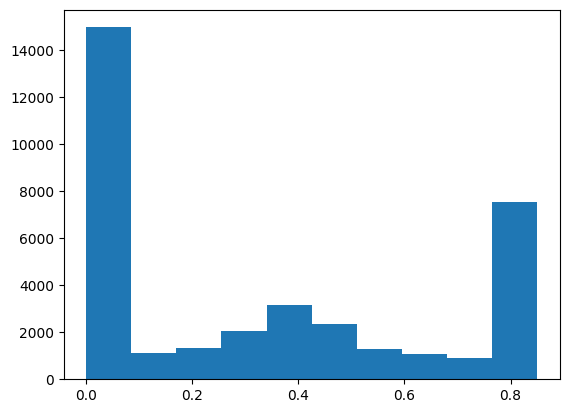

In [6]:
plt.hist(df["Throttle"])

(array([4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 6.000e+00, 6.000e+00, 1.600e+01, 4.300e+01,
        6.700e+01, 1.640e+02, 7.870e+02, 2.207e+03, 2.856e+03, 2.200e+04,
        6.062e+03, 6.330e+02, 3.940e+02, 1.620e+02, 8.100e+01, 8.400e+01,
        8.400e+01, 6.300e+01, 4.400e+01, 2.300e+01, 1.200e+01, 3.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00]),
 array([-8.00000012e-01, -7.66649773e-01, -7.33299535e-01, -6.99949296e-01,
        -6.66599058e-01, -6.33248819e-01, -5.99898581e-01, -5.66548342e-01,
        -5.33198104e-01, -4.99847865e-01, -4.66497627e-01, -4.33147388e-01,
        -3.99797150e-01, -3.66446911e-01, -3.33096673e-01, -2.99746434e-01,
        -2.66396195e-01, -2.33045957e-01, -1.99695718e-01, -1.66345480e-01,
        -1.32995241e-01, -9.96450028e-02, -6.62947643e-02, 

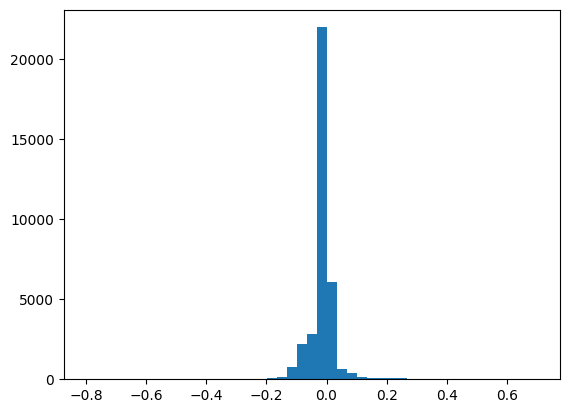

In [7]:
plt.hist(df["Steering"],bins=45)

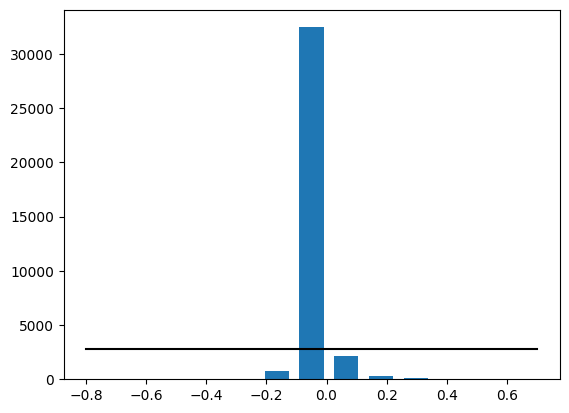

In [8]:
num_bins = 13
avg_samples_per_bin = len(df["Steering"])/num_bins
hist, bins = np.histogram(df["Steering"], num_bins)
samples_per_bin=2693
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(df["Steering"]), np.max(df["Steering"])), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

removed: 29758
remainind df:  6060


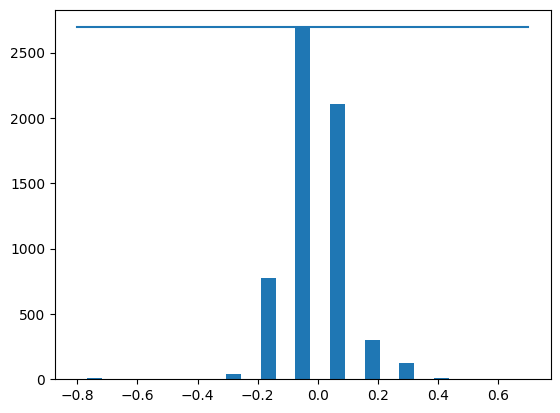

In [9]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(df['Steering'])):
    if df['Steering'][i] >= bins[j] and df['Steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
df.drop(df.index[remove_list], inplace = True)
print('remainind df: ', len(df))
hist, _ = np.histogram(df['Steering'], num_bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(df['Steering']), np.max(df['Steering'])), (samples_per_bin, samples_per_bin))

In [10]:
print(df.iloc[1])

cam_path    pokemon/034373.png
Throttle              0.139771
Steering                   0.0
Braking                    0.0
Name: 20, dtype: object


In [11]:
imagepath=np.asarray(df["cam_path"])
angle=np.asarray(df["Steering"])
throttle=df["Throttle"]
brake=df["Braking"]

In [12]:
imagedata=[]
angle1=[]
for i in range(len(imagepath)):
    if os.path.exists(imagepath[i]):
        try:
            image=cv2.imread(imagepath[i])
        except cv2.error:
            throttle.pop(i)
            brake.pop(i)
            continue
        except AssertionError:
            throttle.pop(i)
            brake.pop(i)
            continue
        else:
            print(imagepath[i])
            print(i)
            image = cv2.GaussianBlur(image, (3,3), 0)
            image= cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            image,angle[i]=random_augment(image,angle[i])
            image_fromarray=Image.fromarray(image,"RGB")
            resize_image=image_fromarray.resize((400,225))
            imagedata.append(np.array(resize_image))
            angle1.append(angle[i])
    else :
        throttle.pop(i)
        brake.pop(i)
        continue
imagedata=np.asarray(imagedata)
angle1=np.asarray(angle)
throttle=np.asarray(throttle)
brake=np.asarray(brake)

pokemon/034173.png
0
pokemon/034373.png
1
pokemon/034623.png
2
pokemon/034653.png
3
pokemon/034873.png
4
pokemon/035053.png
5
pokemon/035293.png
6
pokemon/035313.png
7
pokemon/035533.png
8
pokemon/035573.png
9
pokemon/035753.png
10
pokemon/035783.png
11
pokemon/035833.png
12
pokemon/035993.png
13
pokemon/036103.png
14
pokemon/036333.png
15
pokemon/036353.png
16
pokemon/036363.png
17
pokemon/036493.png
18
pokemon/036523.png
19
pokemon/036553.png
20
pokemon/036573.png
21
pokemon/036593.png
22
pokemon/036703.png
23
pokemon/036713.png
24
pokemon/036743.png
25
pokemon/036753.png
26
pokemon/036773.png
27
pokemon/036823.png
28
pokemon/036943.png
29
pokemon/037043.png
30
pokemon/037083.png
31
pokemon/037103.png
32
pokemon/037153.png
33
pokemon/037203.png
34
pokemon/037303.png
35
pokemon/037443.png
36
pokemon/037453.png
37
pokemon/037733.png
38
pokemon/037793.png
39
pokemon/037953.png
40
pokemon/037963.png
41
pokemon/037973.png
42
pokemon/037983.png
43
pokemon/038083.png
44
pokemon/038113.png
4

In [13]:
imagedata.shape,angle.shape,throttle.shape,brake.shape

((6060, 225, 400, 3), (6060,), (6060,), (6060,))

In [14]:
X_train,X_val,y_train,y_val=train_test_split(imagedata,angle,test_size=.2)

Text(0.5, 1.0, 'Validation Set')

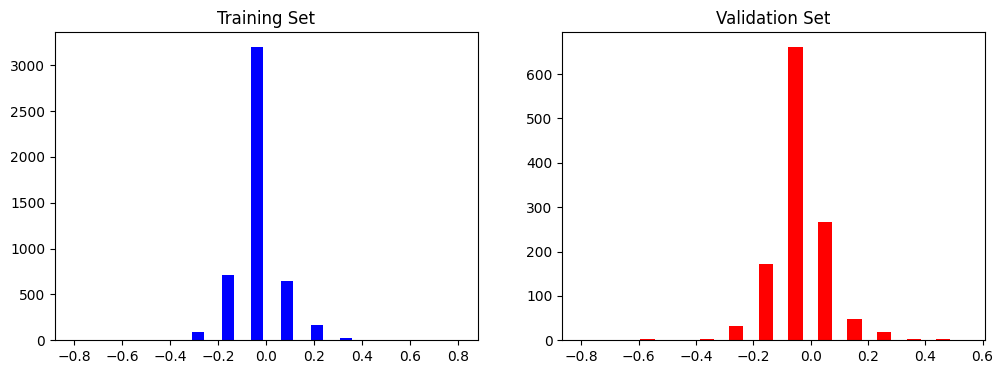

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axs[0].set_title('Training Set')
axs[1].hist(y_val, bins = num_bins, width = 0.05, color = 'red')
axs[1].set_title('Validation Set')

In [16]:
def nvidia_model():
    model = Sequential()

    model.add(Conv2D(24,(5,5), strides=(2, 2), input_shape=(225, 400, 3), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2, 2), activation='elu'))

    model.add(Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))

    model.add(MaxPool2D())


    model.add(Flatten())


    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model
model = nvidia_model()

c:\Users\L\anaconda3\envs\carla-sim\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
mode=model.fit(im_the_generator(X_train,y_train,100,1),validation_data=im_the_generator(X_val,y_val,100,0),epochs=16,steps_per_epoch=300,validation_steps=100,verbose=2,shuffle=1)

Epoch 1/16
300/300 - 10s - loss: 65.9501 - val_loss: 0.1821 - 10s/epoch - 33ms/step
Epoch 2/16
300/300 - 9s - loss: 0.3377 - val_loss: 0.0455 - 9s/epoch - 31ms/step
Epoch 3/16
300/300 - 9s - loss: 0.1578 - val_loss: 0.1435 - 9s/epoch - 29ms/step
Epoch 4/16
300/300 - 9s - loss: 0.1392 - val_loss: 0.0864 - 9s/epoch - 29ms/step
Epoch 5/16
300/300 - 9s - loss: 0.1041 - val_loss: 0.0368 - 9s/epoch - 29ms/step
Epoch 6/16
300/300 - 9s - loss: 0.1213 - val_loss: 0.0676 - 9s/epoch - 29ms/step
Epoch 7/16
300/300 - 9s - loss: 0.0823 - val_loss: 0.0596 - 9s/epoch - 30ms/step
Epoch 8/16
300/300 - 9s - loss: 0.0752 - val_loss: 0.0296 - 9s/epoch - 29ms/step
Epoch 9/16
300/300 - 9s - loss: 0.0711 - val_loss: 0.0719 - 9s/epoch - 30ms/step
Epoch 10/16
300/300 - 9s - loss: 0.1060 - val_loss: 0.0202 - 9s/epoch - 29ms/step
Epoch 11/16
300/300 - 9s - loss: 0.0613 - val_loss: 0.3516 - 9s/epoch - 30ms/step
Epoch 12/16
300/300 - 9s - loss: 0.1046 - val_loss: 0.0615 - 9s/epoch - 29ms/step
Epoch 13/16
300/300 - 

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 111, 198, 24)      1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 97, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 47, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 45, 64)        27712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 22, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                        

In [19]:
model.save_weights('./modela.h5')

model.save('model_a.h5')